<a href="https://colab.research.google.com/github/boneeyah/QTW/blob/main/Case%20Study%202/Case_Study_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import label_binarize, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/KendallScott/QTW/main/Case%20Study%202/diabetic_data.csv")
ID_map = pd.read_csv("https://raw.githubusercontent.com/KendallScott/QTW/main/Case%20Study%202/IDs_mapping.csv")

admission_source = ID_map.drop(['admission_description', 'discharge_description'], axis=1)
admission = ID_map.drop(['admission_source_description', 'discharge_description'], axis=1)
discharge = ID_map.drop(['admission_description', 'admission_source_description'], axis=1)

df=pd.merge(df, admission, 
            left_on='admission_type_id', 
            right_on='id', 
            how='left' 
)


df=pd.merge(df, discharge, 
            left_on='discharge_disposition_id', 
            right_on='id', 
            how='left' 
)
df=pd.merge(df, admission_source, 
            left_on='admission_source_id', 
            right_on='id', 
            how='left' 
)


Upon first inspection there do not appear to be any NAs

In [ ]:
#sorting the dataframe by patient_nbr and encounter_id, in order to filter out the repeat values 
df=df.sort_values(by=['patient_nbr', 'encounter_id'])

#filtering out repeat values by patient_nbr
df=df.groupby('patient_nbr').first()
len(df)

71518

In [ ]:
df = df[df.columns.drop(list(df.filter(regex='_x')))]
df = df[df.columns.drop(list(df.filter(regex='_y')))]
df = df[df.columns.drop(list(df.filter(regex='_id')))]

#removing number emergency, as it is tied to the readmission column we are predicting on
#df = df[df.columns.drop(list(df.filter(regex='number_emergency')))]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71518 entries, 135 to 189502619
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   race                          71518 non-null  object
 1   gender                        71518 non-null  object
 2   age                           71518 non-null  object
 3   weight                        71518 non-null  object
 4   time_in_hospital              71518 non-null  int64 
 5   payer_code                    71518 non-null  object
 6   medical_specialty             71518 non-null  object
 7   num_lab_procedures            71518 non-null  int64 
 8   num_procedures                71518 non-null  int64 
 9   num_medications               71518 non-null  int64 
 10  number_outpatient             71518 non-null  int64 
 11  number_emergency              71518 non-null  int64 
 12  number_inpatient              71518 non-null  int64 
 13  diag_1    

In [ ]:
df.head()

,race,gender,age,weight,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_description,discharge_description,id,admission_source_description
patient_nbr,,,,,,,,,,,,,,,,,,,,,
135,Caucasian,Female,[50-60),?,8,?,Cardiology,77,6,33,...,No,No,No,Ch,Yes,<30,Urgent,Discharged to home,1,Physician Referral
378,Caucasian,Female,[50-60),?,2,?,Surgery-Neuro,49,1,11,...,No,No,No,No,No,NO,Elective,Discharged to home,1,Physician Referral
729,Caucasian,Female,[80-90),?,4,MC,InternalMedicine,68,2,23,...,No,No,No,No,Yes,NO,Emergency,Discharged/transferred to SNF,7,Emergency Room
774,Caucasian,Female,[80-90),?,3,?,InternalMedicine,46,0,20,...,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,7,Emergency Room
927,AfricanAmerican,Female,[30-40),?,5,?,InternalMedicine,49,0,5,...,No,No,No,No,Yes,NO,Emergency,Discharged to home,7,Emergency Room


The weight column has a question mark (?), corresponding to missing weights, these are effectively NAs.
Also, target is not binary in this case, however, our aim is to predict rehospitalization within 30 days, a binary (yes or no) response.


In [ ]:
# Get count duplicates single column using dataframe.pivot_table()
df2 = df.pivot_table(index = ['patient_nbr'], aggfunc ='size')
print(df2)

patient_nbr
135          1
378          1
729          1
774          1
927          1
            ..
189351095    1
189365864    1
189445127    1
189481478    1
189502619    1
Length: 71518, dtype: int64


When we look at the data by patient number, we can see that the number of rows drops from 101,766 down to 71,518. We will be dropping the repeated values.

In [ ]:
for i in df.columns:
  count = df.loc[df[i]=='?',i].count()
  if count > 0:
    print('{}:'.format(i),
          '{}%'.format(np.round(np.divide(count,len(df))*100,2)))

race: 2.72%
weight: 96.01%
payer_code: 43.41%
medical_specialty: 48.21%
diag_1: 0.02%
diag_2: 0.41%
diag_3: 1.71%


Three variables have a large percentage of missing values, Weight, Payer_code and Medical_speciatly with about 97%, 40% and 49% of missing values accordingly. Race and diags 1-3 all have a smaller number of missing values.

In [ ]:
#dropping columns with high # of missing values
df=df.drop(['weight', 'medical_specialty', 'payer_code'], axis=1)


In [ ]:
# Replacing the ? with nan
df=df.replace("?", np.nan)

In [ ]:
df.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,id
count,71518.00000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000
mean,4.28913,43.075478,1.430577,15.705025,0.280069,0.103540,0.177829,7.245700,5.657457
std,2.94921,19.952338,1.759864,8.311163,1.068957,0.509187,0.603790,1.994674,4.162580
min,1.00000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2.00000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,1.000000
50%,3.00000,44.000000,1.000000,14.000000,0.000000,0.000000,0.000000,8.000000,7.000000
75%,6.00000,57.000000,2.000000,20.000000,0.000000,0.000000,0.000000,9.000000,7.000000
max,14.00000,132.000000,6.000000,81.000000,42.000000,42.000000,12.000000,16.000000,25.000000


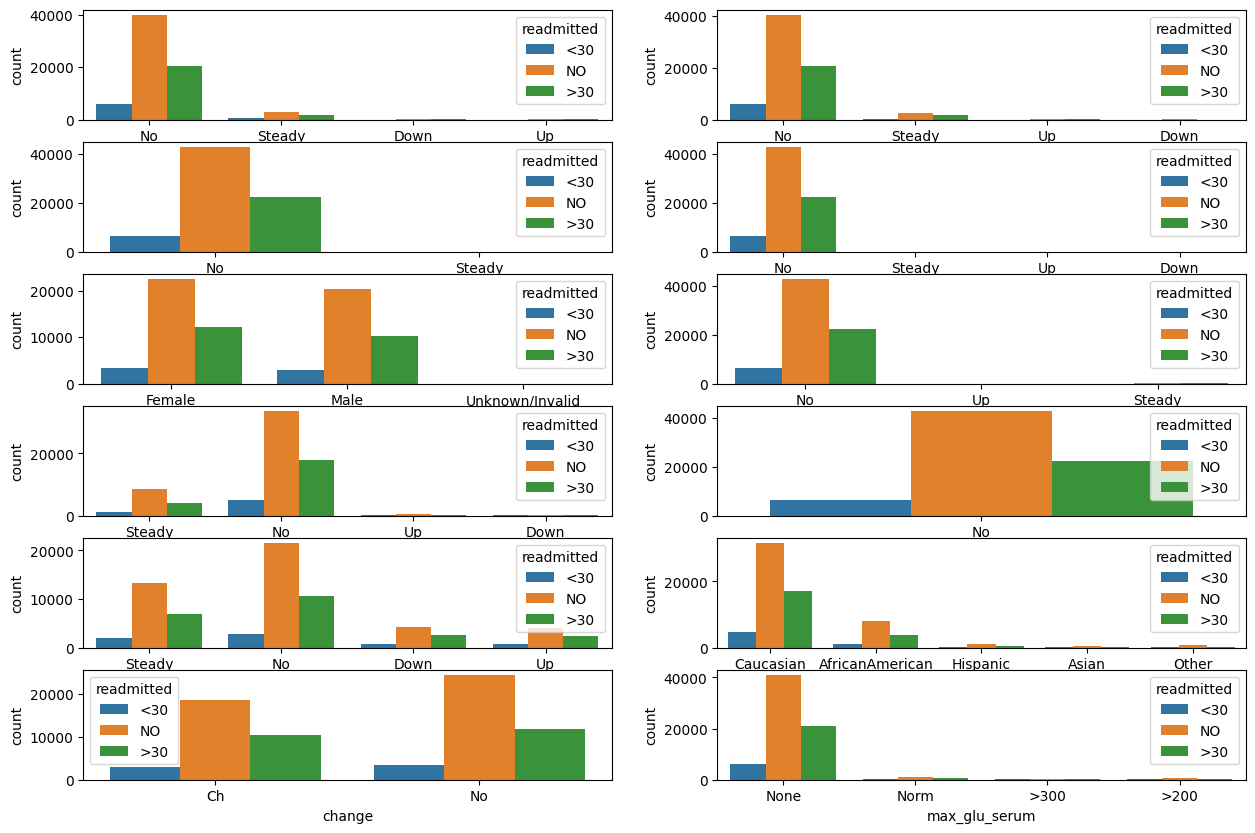

In [ ]:
fig, axes = plt.subplots(6,2, figsize = (15, 10))

sns.countplot(x = 'pioglitazone', data = df, hue = 'readmitted', ax = axes[0, 0]);
sns.countplot(x = 'rosiglitazone', data = df, hue = 'readmitted', ax = axes[0, 1]);

sns.countplot(x = 'metformin-rosiglitazone', data = df, hue = 'readmitted', ax = axes[1, 0]);
sns.countplot(x = 'miglitol', data = df, hue = 'readmitted', ax = axes[1, 1]);

sns.countplot(x = 'gender', data = df, hue = 'readmitted', ax = axes[2, 0]);
sns.countplot(x = 'acarbose', data = df, hue = 'readmitted', ax = axes[2, 1]);

sns.countplot(x = 'metformin', data = df, hue = 'readmitted', ax = axes[3, 0]);
sns.countplot(x = 'citoglipton', data = df, hue = 'readmitted', ax = axes[3, 1]);

sns.countplot(x = 'insulin', data = df, hue = 'readmitted', ax = axes[4, 0]);
sns.countplot(x = 'race', data = df, hue = 'readmitted', ax = axes[4, 1]);

sns.countplot(x = 'change', data = df, hue = 'readmitted', ax = axes[5, 0]);
sns.countplot(x = 'max_glu_serum', data = df, hue = 'readmitted', ax = axes[5, 1]);

While we saw some differences in readmission by race, there was no measure of the confounding factors for implicit racial bias, therefore that variable was excluded as a factor from the model.

Other research has shown that African American's have lower medical intervention, but that has been an indication of racial bias within the medical community previously (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3797360/_).

In [ ]:
df=df.drop(['race'], axis=1)

In [ ]:
df.head()

,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,...,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_description,discharge_description,id,admission_source_description
patient_nbr,,,,,,,,,,,,,,,,,,,,,
135,Female,[50-60),8,77,6,33,0,0,0,401,...,No,No,No,Ch,Yes,<30,Urgent,Discharged to home,1,Physician Referral
378,Female,[50-60),2,49,1,11,0,0,0,722,...,No,No,No,No,No,NO,Elective,Discharged to home,1,Physician Referral
729,Female,[80-90),4,68,2,23,0,0,0,820,...,No,No,No,No,Yes,NO,Emergency,Discharged/transferred to SNF,7,Emergency Room
774,Female,[80-90),3,46,0,20,0,0,0,274,...,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,7,Emergency Room
927,Female,[30-40),5,49,0,5,0,0,0,590,...,No,No,No,No,Yes,NO,Emergency,Discharged to home,7,Emergency Room


In [ ]:
#filtering out expired and hospice patients
df = df[df["discharge_description"] != 'Expired']
df = df[df["discharge_description"] != 'Expired at home. Medicaid only, hospice.']
df = df[df["discharge_description"] != 'Hospice / home']
df = df[df["discharge_description"] != 'Hospice / medical facility']

In [ ]:
df[['readmitted','change']].groupby('change').describe()

readmitted                  
            count unique top   freq
change                             
Ch          31489      3  NO  18047
No          38474      3  NO  23428

In [ ]:
df[['readmitted','admission_description']].groupby('admission_description').describe()

readmitted                  
                           count unique top   freq
admission_description                             
Elective                   13846      3  NO   8915
Emergency                  35671      3  NO  20777
Newborn                        9      3  NO      6
Not Available               3121      3  NO   1783
Not Mapped                   291      3  NO    201
Trauma Center                 18      1  NO     18
Urgent                     12847      3  NO   7583

Admission code 1-Emergency, 2-Urgent, 3-Elective, 4-Newborn, 5-NotAvailable, 6-NULL, 7-Trauma Center, 8-NotMapped.
For Not Mapped and Null admission categories, the missing payer code is seen on almost all patients. Based on the levels of the payer code category, it would seem as if the missing value corresponds to patients who did not disclose a payment method (insurance or self-pay), which in itself, is a category level.

In [ ]:
df.readmitted.value_counts()
# >30 does not count as within 30 days for our target, will replace

NO     41475
>30    22212
<30     6276
Name: readmitted, dtype: int64

In [ ]:
#removing information from the dataframe, which are tied to information after a patient was admitted(isolating to information for initial admission)
df =  df[df.columns.drop(list(df.filter(regex='discharge')))]
df = df[df.columns.drop(list(df.filter(regex='time_in_hospital')))]
df = df[df.columns.drop(list(df.filter(regex='diag_2')))]
df = df[df.columns.drop(list(df.filter(regex='diag_3')))]

In [ ]:
y = df.readmitted.replace(to_replace='>30',value='NO')
y = label_binarize(y,classes=['NO','<30'])

In [ ]:
# Make dataframe for model input
X = df.loc[:, df.columns != 'readmitted']

#remove repeated categorical columns for description, and discharge column, which has some values of the predictor
X = X[X.columns.drop(list(X.filter(regex='_id')))]

#one hot encoding categorical variables for model
cols = X.columns
num_cols = X._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

#creating dataframe of categorical columns
cat_df = X[cat_cols]
cat_df = pd.get_dummies(cat_df, columns=cat_df.columns)

#creating dataframe of numeric columns
num_df = X[num_cols]

X=cat_df.join(num_df)
X


,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100),...,acarbose_Steady,acarbose_Up,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,id
patient_nbr,,,,,,,,,,,,,,,,,,,,,
135,0,0,0,0,0,1,0,0,0,0,...,0,0,77,6,33,0,0,0,8,1
378,0,0,0,0,0,1,0,0,0,0,...,0,0,49,1,11,0,0,0,3,1
729,0,0,0,0,0,0,0,0,1,0,...,0,0,68,2,23,0,0,0,9,7
774,0,0,0,0,0,0,0,0,1,0,...,0,0,46,0,20,0,0,0,9,7
927,0,0,0,1,0,0,0,0,0,0,...,0,0,49,0,5,0,0,0,3,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189351095,0,0,0,0,0,0,0,0,1,0,...,0,0,73,1,11,0,0,0,9,7
189365864,0,0,0,0,0,0,1,0,0,0,...,0,0,56,1,8,0,0,0,7,7
189445127,0,0,0,0,0,0,0,0,1,0,...,0,0,39,0,18,0,0,0,9,7


In [ ]:
accuracy = []

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y.flatten(), 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Create a logistic regression model
model = LogisticRegression(class_weight = "balanced",n_jobs=-1,max_iter = 3000, C=10) # 3000 iter to converge C 10 from grid search

# Train the model on the training data
model.fit(X_train, y_train)

# Predict on the testing data
y_pred = model.predict(X_test)

#confusion matrix
cr = classification_report(y_test,y_pred)
print(cr)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9072393339526906


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
grid = {'C':[.1,.25,.5,1,2,5,10]}
model = LogisticRegression(random_state=42,class_weight='balanced',max_iter=3000)
search = GridSearchCV(model,grid,scoring='recall',cv = 5,n_jobs=-1)
results = search.fit(X,y.flatten())
print(results.best_score_)
print(results.best_params_)
# this finds C = 10.

Due to an excessively high prediction, we investigated which columns may be providing information on the predictive variable.

In [ ]:
Weights = pd.Series(model.coef_[0], index = X.columns)
Weights = pd.DataFrame({'Var':Weights.index, 'Weight':Weights.values})
Weights = Weights.sort_values('Weight')
idx = Weights['Weight'].abs().sort_values(ascending = False).head(20).index
Weights2 = Weights.loc[idx]
Weights2

,Var,Weight
289,diag_1_434,0.909683
541,diag_1_786,-0.573626
572,diag_1_820,0.397431
132,diag_1_250.7,0.382842
701,diag_1_V58,0.342502
816,number_inpatient,0.317275
332,diag_1_486,-0.303275
283,diag_1_428,0.269023
294,diag_1_440,0.259020
792,repaglinide_No,-0.248398


In [ ]:
#checkign for categories with minimal variation to drop, due to overfitted model

for i in X.columns:
  count = X.loc[X[i]==1,i].count()
  if count > 0:
    print('{}:'.format(i),
          '{}%'.format(np.round(np.divide(count,len(X))*100,2)))


age_[0-10): 0.22%
age_[10-20): 0.76%
age_[20-30): 1.6%
age_[30-40): 3.85%
age_[40-50): 9.76%
age_[50-60): 17.65%
age_[60-70): 22.42%
age_[70-80): 25.36%
age_[80-90): 15.87%
age_[90-100): 2.52%
metformin-pioglitazone_No: 100.0%
metformin-pioglitazone_Steady: 0.0%
examide_No: 100.0%
diag_1_10: 0.0%
diag_1_11: 0.01%
diag_1_110: 0.0%
diag_1_112: 0.06%
diag_1_114: 0.0%
diag_1_115: 0.0%
diag_1_117: 0.01%
diag_1_131: 0.0%
diag_1_133: 0.0%
diag_1_135: 0.03%
diag_1_136: 0.01%
diag_1_141: 0.01%
diag_1_142: 0.01%
diag_1_143: 0.0%
diag_1_145: 0.0%
diag_1_146: 0.0%
diag_1_147: 0.0%
diag_1_148: 0.0%
diag_1_149: 0.0%
diag_1_150: 0.03%
diag_1_151: 0.06%
diag_1_152: 0.01%
diag_1_153: 0.36%
diag_1_154: 0.11%
diag_1_155: 0.05%
diag_1_156: 0.02%
diag_1_157: 0.11%
diag_1_158: 0.01%
diag_1_160: 0.0%
diag_1_161: 0.01%
diag_1_162: 0.38%
diag_1_163: 0.01%
diag_1_164: 0.0%
diag_1_170: 0.0%
diag_1_171: 0.01%
diag_1_172: 0.0%
diag_1_173: 0.0%
diag_1_174: 0.18%
diag_1_175: 0.01%
diag_1_179: 0.0%
diag_1_180: 0.01%


In [ ]:
df=df.drop(['troglitazone','metformin-pioglitazone','rosiglitazone','acarbose','acetohexamide', 'citoglipton', 'glipizide-metformin', 'nateglinide', 'citoglipton', 'pioglitazone', 'tolbutamide', 'glyburide-metformin', 'tolazamide', 'glimepiride', 'miglitol', 'repaglinide', 'chlorpropamide', 'max_glu_serum', 'metformin-rosiglitazone'], axis=1)

# Make dataframe for model input
X = df.loc[:, df.columns != 'readmitted']

#remove repeated categorical columns for description, and discharge column, which has some values of the predictor
X = X[X.columns.drop(list(X.filter(regex='_id')))]


#one hot encoding categorical variables for model
cols = X.columns
num_cols = X._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

#creating dataframe of categorical columns
cat_df = X[cat_cols]
cat_df = pd.get_dummies(cat_df, columns=cat_df.columns)

#creating dataframe of numeric columns
num_df = X[num_cols]

X=cat_df.join(num_df)
X=X.drop(['admission_description_Newborn',
 'admission_source_description_ Born inside this hospital',
 'admission_source_description_ Court/Law Enforcement',
 'admission_source_description_ Extramural Birth',
 'admission_source_description_ Not Available',
 'admission_source_description_ Transfer from a Skilled Nursing Facility (SNF)',
 'admission_source_description_ Transfer from critial access hospital',
 'admission_source_description_Normal Delivery' ,
 'admission_description_Trauma Center',
 'admission_source_description_Unknown/Invalid',
 'diag_1_10',
 'diag_1_11',
 'diag_1_110',
 'diag_1_112',
 'diag_1_114',
 'diag_1_115',
 'diag_1_117',
 'diag_1_131',
 'diag_1_133',
 'diag_1_135',
 'diag_1_136',
 'diag_1_141',
 'diag_1_142',
 'diag_1_143',
 'diag_1_145',
 'diag_1_146',
 'diag_1_147',
 'diag_1_148',
 'diag_1_149',
 'diag_1_150',
 'diag_1_151',
 'diag_1_152',
 'diag_1_155',
 'diag_1_156',
 'diag_1_158',
 'diag_1_160',
 'diag_1_161',
 'diag_1_163',
 'diag_1_164',
 'diag_1_170',
 'diag_1_171',
 'diag_1_172',
 'diag_1_173',
 'diag_1_175',
 'diag_1_179',
 'diag_1_180',
 'diag_1_183',
 'diag_1_184',
 'diag_1_187',
 'diag_1_191',
 'diag_1_192',
 'diag_1_193',
 'diag_1_194',
 'diag_1_195',
 'diag_1_196',
 'diag_1_199',
 'diag_1_200',
 'diag_1_201',
 'diag_1_203',
 'diag_1_204',
 'diag_1_205',
 'diag_1_207',
 'diag_1_208',
 'diag_1_210',
 'diag_1_212',
 'diag_1_214',
 'diag_1_215',
 'diag_1_216',
 'diag_1_217',
 'diag_1_219',
 'diag_1_220',
 'diag_1_223',
 'diag_1_225',
 'diag_1_226',
 'diag_1_227',
 'diag_1_228',
 'diag_1_229',
 'diag_1_230',
 'diag_1_233',
 'diag_1_235',
 'diag_1_236',
 'diag_1_237',
 'diag_1_238',
 'diag_1_239',
 'diag_1_240',
 'diag_1_241',
 'diag_1_242',
 'diag_1_244',
 'diag_1_245',
 'diag_1_246',
 'diag_1_250.01',
 'diag_1_250.21',
 'diag_1_250.23',
 'diag_1_250.3',
 'diag_1_250.31',
 'diag_1_250.32',
 'diag_1_250.33',
 'diag_1_250.41',
 'diag_1_250.42',
 'diag_1_250.43',
 'diag_1_250.5',
 'diag_1_250.51',
 'diag_1_250.52',
 'diag_1_250.53',
 'diag_1_250.9',
 'diag_1_250.91',
 'diag_1_250.92',
 'diag_1_250.93',
 'diag_1_251',
 'diag_1_252',
 'diag_1_253',
 'diag_1_255',
 'diag_1_261',
 'diag_1_262',
 'diag_1_263',
 'diag_1_266',
 'diag_1_27',
 'diag_1_272',
 'diag_1_273',
 'diag_1_275',
 'diag_1_277',
 'diag_1_281',
 'diag_1_282',
 'diag_1_283',
 'diag_1_284',
 'diag_1_286',
 'diag_1_287',
 'diag_1_288',
 'diag_1_289',
 'diag_1_290',
 'diag_1_293',
 'diag_1_297',
 'diag_1_298',
 'diag_1_299',
 'diag_1_3',
 'diag_1_300',
 'diag_1_301',
 'diag_1_303',
 'diag_1_304',
 'diag_1_305',
 'diag_1_306',
 'diag_1_307',
 'diag_1_308',
 'diag_1_309',
 'diag_1_31',
 'diag_1_310',
 'diag_1_311',
 'diag_1_312',
 'diag_1_314',
 'diag_1_318',
 'diag_1_320',
 'diag_1_322',
 'diag_1_323',
 'diag_1_324',
 'diag_1_325',
 'diag_1_327',
 'diag_1_332',
 'diag_1_333',
 'diag_1_334',
 'diag_1_335',
 'diag_1_336',
 'diag_1_337',
 'diag_1_338',
 'diag_1_34',
 'diag_1_340',
 'diag_1_341',
 'diag_1_342',
 'diag_1_344',
 'diag_1_346',
 'diag_1_347',
 'diag_1_349',
 'diag_1_35',
 'diag_1_350',
 'diag_1_351',
 'diag_1_352',
 'diag_1_353',
 'diag_1_354',
 'diag_1_355',
 'diag_1_356',
 'diag_1_357',
 'diag_1_358',
 'diag_1_359',
 'diag_1_36',
 'diag_1_360',
 'diag_1_361',
 'diag_1_362',
 'diag_1_363',
 'diag_1_365',
 'diag_1_366',
 'diag_1_368',
 'diag_1_369',
 'diag_1_370',
 'diag_1_374',
 'diag_1_375',
 'diag_1_376',
 'diag_1_377',
 'diag_1_378',
 'diag_1_379',
 'diag_1_380',
 'diag_1_381',
 'diag_1_382',
 'diag_1_383',
 'diag_1_384',
 'diag_1_385',
 'diag_1_388',
 'diag_1_39',
 'diag_1_391',
 'diag_1_394',
 'diag_1_395',
 'diag_1_396',
 'diag_1_397',
 'diag_1_398',
 'diag_1_405',
 'diag_1_41',
 'diag_1_412',
 'diag_1_416',
 'diag_1_417',
 'diag_1_42',
 'diag_1_420',
 'diag_1_421',
 'diag_1_422',
 'diag_1_423',
 'diag_1_425',
 'diag_1_429',
 'diag_1_430',
 'diag_1_432',
 'diag_1_438',
 'diag_1_442',
 'diag_1_443',
 'diag_1_445',
 'diag_1_446',
 'diag_1_447',
 'diag_1_448',
 'diag_1_451',
 'diag_1_452',
 'diag_1_454',
 'diag_1_456',
 'diag_1_457',
 'diag_1_459',
 'diag_1_461',
 'diag_1_462',
 'diag_1_463',
 'diag_1_464',
 'diag_1_465',
 'diag_1_47',
 'diag_1_470',
 'diag_1_471',
 'diag_1_473',
 'diag_1_474',
 'diag_1_475',
 'diag_1_477',
 'diag_1_478',
 'diag_1_48',
 'diag_1_480',
 'diag_1_481',
 'diag_1_483',
 'diag_1_485',
 'diag_1_49',
 'diag_1_490',
 'diag_1_492',
 'diag_1_494',
 'diag_1_495',
 'diag_1_496',
 'diag_1_5',
 'diag_1_500',
 'diag_1_501',
 'diag_1_508',
 'diag_1_510',
 'diag_1_512',
 'diag_1_513',
 'diag_1_514',
 'diag_1_516',
 'diag_1_519',
 'diag_1_52',
 'diag_1_521',
 'diag_1_522',
 'diag_1_524',
 'diag_1_526',
 'diag_1_527',
 'diag_1_528',
 'diag_1_529',
 'diag_1_53',
 'diag_1_533',
 'diag_1_534',
 'diag_1_537',
 'diag_1_54',
 'diag_1_541',
 'diag_1_542',
 'diag_1_550',
 'diag_1_551',
 'diag_1_555',
 'diag_1_556',
 'diag_1_565',
 'diag_1_567',
 'diag_1_568',
 'diag_1_57',
 'diag_1_570',
 'diag_1_573',
 'diag_1_579',
 'diag_1_580',
 'diag_1_581',
 'diag_1_582',
 'diag_1_583',
 'diag_1_585',
 'diag_1_586',
 'diag_1_588',
 'diag_1_591',
 'diag_1_593',
 'diag_1_594',
 'diag_1_595',
 'diag_1_596',
 'diag_1_598',
 'diag_1_601',
 'diag_1_602',
 'diag_1_603',
 'diag_1_604',
 'diag_1_605',
 'diag_1_607',
 'diag_1_608',
 'diag_1_61',
 'diag_1_610',
 'diag_1_611',
 'diag_1_614',
 'diag_1_615',
 'diag_1_616',
 'diag_1_617',
 'diag_1_619',
 'diag_1_620',
 'diag_1_621',
 'diag_1_622',
 'diag_1_623',
 'diag_1_625',
 'diag_1_627',
 'diag_1_632',
 'diag_1_633',
 'diag_1_634',
 'diag_1_637',
 'diag_1_640',
 'diag_1_641',
 'diag_1_642',
 'diag_1_643',
 'diag_1_644',
 'diag_1_645',
 'diag_1_646',
 'diag_1_647',
 'diag_1_649',
 'diag_1_652',
 'diag_1_653',
 'diag_1_655',
 'diag_1_656',
 'diag_1_657',
 'diag_1_658',
 'diag_1_659',
 'diag_1_66',
 'diag_1_660',
 'diag_1_661',
 'diag_1_663',
 'diag_1_664',
 'diag_1_665',
 'diag_1_669',
 'diag_1_671',
 'diag_1_674',
 'diag_1_680',
 'diag_1_683',
 'diag_1_684',
 'diag_1_685',
 'diag_1_686',
 'diag_1_690',
 'diag_1_691',
 'diag_1_692',
 'diag_1_693',
 'diag_1_694',
 'diag_1_695',
 'diag_1_696',
 'diag_1_7',
 'diag_1_70',
 'diag_1_700',
 'diag_1_703',
 'diag_1_704',
 'diag_1_705',
 'diag_1_706',
 'diag_1_708',
 'diag_1_709',
 'diag_1_710',
 'diag_1_711',
 'diag_1_714',
 'diag_1_716',
 'diag_1_717',
 'diag_1_718',
 'diag_1_719',
 'diag_1_720',
 'diag_1_723',
 'diag_1_725',
 'diag_1_727',
 'diag_1_732',
 'diag_1_734',
 'diag_1_735',
 'diag_1_736',
 'diag_1_737',
 'diag_1_738',
 'diag_1_745',
 'diag_1_746',
 'diag_1_747',
 'diag_1_75',
 'diag_1_751',
 'diag_1_753',
 'diag_1_756',
 'diag_1_759',
 'diag_1_78',
 'diag_1_782',
 'diag_1_783',
 'diag_1_788',
 'diag_1_791',
 'diag_1_792',
 'diag_1_793',
 'diag_1_794',
 'diag_1_795',
 'diag_1_796',
 'diag_1_797',
 'diag_1_799',
 'diag_1_800',
 'diag_1_801',
 'diag_1_802',
 'diag_1_803',
 'diag_1_806',
 'diag_1_807',
 'diag_1_810',
 'diag_1_814',
 'diag_1_815',
 'diag_1_816',
 'diag_1_817',
 'diag_1_82',
 'diag_1_822',
 'diag_1_825',
 'diag_1_826',
 'diag_1_831',
 'diag_1_832',
 'diag_1_833',
 'diag_1_834',
 'diag_1_835',
 'diag_1_836',
 'diag_1_837',
 'diag_1_838',
 'diag_1_839',
 'diag_1_84',
 'diag_1_840',
 'diag_1_842',
 'diag_1_843',
 'diag_1_844',
 'diag_1_845',
 'diag_1_846',
 'diag_1_847',
 'diag_1_848',
 'diag_1_850',
 'diag_1_851',
 'diag_1_853',
 'diag_1_854',
 'diag_1_860',
 'diag_1_861',
 'diag_1_862',
 'diag_1_863',
 'diag_1_864',
 'diag_1_865',
 'diag_1_866',
 'diag_1_867',
 'diag_1_868',
 'diag_1_870',
 'diag_1_871',
 'diag_1_873',
 'diag_1_875',
 'diag_1_878',
 'diag_1_879',
 'diag_1_88',
 'diag_1_880',
 'diag_1_881',
 'diag_1_882',
 'diag_1_883',
 'diag_1_885',
 'diag_1_886',
 'diag_1_890',
 'diag_1_891',
 'diag_1_892',
 'diag_1_893',
 'diag_1_897',
 'diag_1_9',
 'diag_1_903',
 'diag_1_904',
 'diag_1_906',
 'diag_1_911',
 'diag_1_913',
 'diag_1_914',
 'diag_1_915',
 'diag_1_916',
 'diag_1_917',
 'diag_1_920',
 'diag_1_921',
 'diag_1_922',
 'diag_1_923',
 'diag_1_924',
 'diag_1_928',
 'diag_1_933',
 'diag_1_934',
 'diag_1_935',
 'diag_1_936',
 'diag_1_939',
 'diag_1_94',
 'diag_1_941',
 'diag_1_942',
 'diag_1_944',
 'diag_1_945',
 'diag_1_952',
 'diag_1_955',
 'diag_1_957',
 'diag_1_958',
 'diag_1_959',
 'diag_1_962',
 'diag_1_963',
 'diag_1_964',
 'diag_1_965',
 'diag_1_966',
 'diag_1_967',
 'diag_1_968',
 'diag_1_969',
 'diag_1_970',
 'diag_1_971',
 'diag_1_972',
 'diag_1_975',
 'diag_1_976',
 'diag_1_977',
 'diag_1_98',
 'diag_1_980',
 'diag_1_982',
 'diag_1_983',
 'diag_1_986',
 'diag_1_987',
 'diag_1_989',
 'diag_1_990',
 'diag_1_991',
 'diag_1_992',
 'diag_1_994',
 'diag_1_995',
 'diag_1_999',
 'diag_1_E909',
 'diag_1_V25',
 'diag_1_V26',
 'diag_1_V43',
 'diag_1_V45',
 'diag_1_V51',
 'diag_1_V53',
 'diag_1_V54',
 'diag_1_V55',
 'diag_1_V56',
 'diag_1_V60',
 'diag_1_V63',
 'diag_1_V67',
 'diag_1_V70', 
 'gender_Unknown/Invalid', 
 'admission_source_description_ Sick Baby', 
 'admission_source_description_HMO Referral', 
 'admission_description_Not Mapped', 
 'diag_1_626',
 'diag_1_648',
 'diag_1_654',
 'diag_1_681',
 'diag_1_707',
 'diag_1_721',
 'diag_1_726',
 'diag_1_8',
 'diag_1_V71',
 'diag_1_V58',
 'diag_1_722',
 'diag_1_724',
 'diag_1_726',
 'diag_1_728',
 'diag_1_729',
 'id', 
 'diag_1_560',
'diag_1_562',
'diag_1_564',
'diag_1_566',
'diag_1_569',
'diag_1_571',
'diag_1_572',
'diag_1_574',
'diag_1_575',
'diag_1_576',
'diag_1_577',
'diag_1_578',
'diag_1_584',
'diag_1_590',
'diag_1_592',
'diag_1_599',
'diag_1_600',
'diag_1_618',
'diag_1_682',
'diag_1_715',
'diag_1_730',
'diag_1_733',
'diag_1_780',
'diag_1_781',
'diag_1_784',
'diag_1_785',
'diag_1_786',
'diag_1_787',
'diag_1_789',
'diag_1_79',
'diag_1_790',
'diag_1_805',
'diag_1_808',
'diag_1_812',
'diag_1_813',
'diag_1_820',
'diag_1_821',
'diag_1_823',
'diag_1_824',
'diag_1_852',
'diag_1_996',
'diag_1_997',
'diag_1_998',
'diag_1_V57', 
'diag_1_153',
'diag_1_154',
'diag_1_157',
'diag_1_162',
'diag_1_174',
'diag_1_182',
'diag_1_185',
'diag_1_188',
'diag_1_189',
'diag_1_197',
'diag_1_198',
'diag_1_202',
'diag_1_211',
'diag_1_218',
'diag_1_250',
'diag_1_250.02',
'diag_1_250.03',
'diag_1_250.1',
'diag_1_250.11',
'diag_1_250.12',
'diag_1_250.13',
'diag_1_250.2',
'diag_1_250.22',
'diag_1_250.4',
'diag_1_250.6',
'diag_1_250.7',
'diag_1_250.8',
'diag_1_250.81',
'diag_1_250.82',
'diag_1_250.83',
'diag_1_274',
'diag_1_276',
'diag_1_278',
'diag_1_280',
'diag_1_285',
'diag_1_291',
'diag_1_292',
'diag_1_294',
'diag_1_295',
'diag_1_296',
'diag_1_331',
'diag_1_345',
'diag_1_348',
'diag_1_38',
'diag_1_386',
'diag_1_401',
'diag_1_402',
'diag_1_403',
'diag_1_404',
'diag_1_410',
'diag_1_411',
'diag_1_413',
'diag_1_414',
'diag_1_415',
'diag_1_424',
'diag_1_426',
'diag_1_427',
'diag_1_428',
'diag_1_431',
'diag_1_433',
'diag_1_434',
'diag_1_435',
'diag_1_436',
'diag_1_437',
'diag_1_440',
'diag_1_441',
'diag_1_444',
'diag_1_453',
'diag_1_455',
'diag_1_458',
'diag_1_466',
'diag_1_482',
'diag_1_486',
'diag_1_487',
'diag_1_491',
'diag_1_493',
'diag_1_507',
'diag_1_511',
'diag_1_515',
'diag_1_518',
'diag_1_530',
'diag_1_531',
'diag_1_532',
'diag_1_535',
'diag_1_536',
'diag_1_540',
'diag_1_552',
'diag_1_553',
'diag_1_557',
'diag_1_558'],
 axis=1)

In [ ]:
X.columns

Index(['age_[0-10)', 'age_[10-20)', 'age_[20-30)', 'age_[30-40)',
       'age_[40-50)', 'age_[50-60)', 'age_[60-70)', 'age_[70-80)',
       'age_[80-90)', 'age_[90-100)', 'glipizide_Down', 'glipizide_No',
       'glipizide_Steady', 'glipizide_Up', 'glyburide_Down', 'glyburide_No',
       'glyburide_Steady', 'glyburide_Up', 'examide_No', 'insulin_Down',
       'insulin_No', 'insulin_Steady', 'insulin_Up', 'gender_Female',
       'gender_Male', 'admission_description_Elective',
       'admission_description_Emergency',
       'admission_description_Not Available', 'admission_description_Urgent',
       'metformin_Down', 'metformin_No', 'metformin_Steady', 'metformin_Up',
       'admission_source_description_ Emergency Room',
       'admission_source_description_ Physician Referral',
       'admission_source_description_ Transfer From Another Home Health Agency',
       'admission_source_description_ Transfer from another health care facility',
       'admission_source_description_Clinic 

In [ ]:
#checkign for categories with minimal variation to drop, due to overfitted model

for i in X.columns:
  count = X.loc[X[i]==0,i].count()
  if count > 0:
    print('{}:'.format(i),
          '{}%'.format(np.round(np.divide(count,len(X))*100,2)))


age_[0-10): 99.78%
age_[10-20): 99.24%
age_[20-30): 98.4%
age_[30-40): 96.15%
age_[40-50): 90.24%
age_[50-60): 82.35%
age_[60-70): 77.58%
age_[70-80): 74.64%
age_[80-90): 84.13%
age_[90-100): 97.48%
glipizide_Down: 99.47%
glipizide_No: 12.87%
glipizide_Steady: 88.48%
glipizide_Up: 99.18%
glyburide_Down: 99.4%
glyburide_No: 11.11%
glyburide_Steady: 90.36%
glyburide_Up: 99.12%
insulin_Down: 89.54%
insulin_No: 51.05%
insulin_Steady: 69.11%
insulin_Up: 90.31%
gender_Female: 46.79%
gender_Male: 53.21%
admission_description_Elective: 80.21%
admission_description_Emergency: 49.01%
admission_description_Not Available: 95.54%
admission_description_Urgent: 81.64%
metformin_Down: 99.38%
metformin_No: 21.3%
metformin_Steady: 80.52%
metformin_Up: 98.81%
admission_source_description_ Emergency Room: 46.75%
admission_source_description_ Physician Referral: 68.92%
admission_source_description_ Transfer From Another Home Health Agency: 93.11%
admission_source_description_ Transfer from another health c

In [ ]:
Xalt=X.join(y_alt)
cormat = Xalt.corr()
cormat['readmitted_<30']

age_[0-10)                                                                 -0.011484
age_[10-20)                                                                -0.012588
age_[20-30)                                                                -0.006995
age_[30-40)                                                                -0.013908
age_[40-50)                                                                -0.017937
age_[50-60)                                                                -0.029991
age_[60-70)                                                                 0.000499
age_[70-80)                                                                 0.025878
age_[80-90)                                                                 0.027282
age_[90-100)                                                                0.003232
glipizide_Down                                                              0.010138
glipizide_No                                                     

In [ ]:
#creating dataframe to find where there is high readmitted rates for a variable
y_alt = df[['readmitted']]

y_alt = pd.get_dummies(y_alt, columns=y_alt.columns)

y_alt = y_alt[y_alt.columns.drop(list(y_alt.filter(regex='readmitted_''>30')))]
y_alt = y_alt[y_alt.columns.drop(list(y_alt.filter(regex='readmitted_NO')))]


In [ ]:
X.columns

Index(['age_[0-10)', 'age_[10-20)', 'age_[20-30)', 'age_[30-40)',
       'age_[40-50)', 'age_[50-60)', 'age_[60-70)', 'age_[70-80)',
       'age_[80-90)', 'age_[90-100)', 'glipizide_Down', 'glipizide_No',
       'glipizide_Steady', 'glipizide_Up', 'glyburide_Down', 'glyburide_No',
       'glyburide_Steady', 'glyburide_Up', 'examide_No', 'insulin_Down',
       'insulin_No', 'insulin_Steady', 'insulin_Up', 'gender_Female',
       'gender_Male', 'admission_description_Elective',
       'admission_description_Emergency',
       'admission_description_Not Available', 'admission_description_Urgent',
       'metformin_Down', 'metformin_No', 'metformin_Steady', 'metformin_Up',
       'admission_source_description_ Emergency Room',
       'admission_source_description_ Physician Referral',
       'admission_source_description_ Transfer From Another Home Health Agency',
       'admission_source_description_ Transfer from another health care facility',
       'admission_source_description_Clinic 

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y_alt, random_state=0)

# Create a logistic regression model
model = LogisticRegression(penalty='l1', solver='saga').fit(X_train, y_train)

# Train the model on the training data
model.fit(X_train, y_train)

# Predict on the testing data
y_pred = model.predict(X_val)

# Calculate the accuracy of model
accuracy = accuracy_score(y_val, y_pred)
print(accuracy)

     

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9114973414899091


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
Weights = pd.Series(model.coef_[0], index = X.columns)
Weights = pd.DataFrame({'Var':Weights.index, 'Weight':Weights.values})
Weights = Weights.sort_values('Weight')
idx = Weights['Weight'].abs().sort_values(ascending = False).head(20).index
Weights2 = Weights.loc[idx]
Weights2

,Var,Weight
0,age_[0-10),-0.959747
24,gender_Male,-0.621243
23,gender_Female,-0.619332
18,examide_No,-0.581768
40,diabetesMed_No,-0.532627
46,change_Ch,-0.370393
54,number_inpatient,0.339735
41,diabetesMed_Yes,-0.324107
47,change_No,-0.301986
1,age_[10-20),-0.281640


# maybe this will help?? 

https://github.com/Badr-MOUFAD/beyond-OLS-med-supp-material/blob/main/notebooks/2_feature_selection.ipynb